# How to be more realistic in our synthetic dataset?
---

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def plot_power_spectrum(time_series, sampling_rate, threshold, axis):
    # Compute the FFT
    fft = np.fft.fft(time_series)
    
    # Compute the power spectrum
    power_spectrum = np.abs(fft)**2
    
    # Determine the corresponding frequencies
    frequencies = np.fft.fftfreq(len(time_series), 1/sampling_rate)
    
    # Find the indices of relevant frequencies above the threshold
    relevant_indices = np.where(power_spectrum > threshold)[0]
    
    # Extract the relevant frequencies and power spectrum values
    relevant_frequencies = frequencies[relevant_indices]
    relevant_power_spectrum = power_spectrum[relevant_indices]

    idx = np.argsort(relevant_frequencies)

    # Plot the power spectrum
    axis.plot(relevant_frequencies[idx], relevant_power_spectrum[idx])
    axis.set_xlabel('Frequency')
    axis.set_ylabel('Power Spectrum')
    axis.set_title('Power Spectrum')

    # Set x-axis limits to show positive frequencies only
    axis.set_xlim(0, max(relevant_frequencies))

    # Set y-axis scale to logarithmic for better visualization
    axis.set_yscale('log')
    return relevant_frequencies

In [28]:
from data._main import get_dataset
from omegaconf import OmegaConf

Chosen dataset(s): ['Flavell2023']
Num. worms: 50



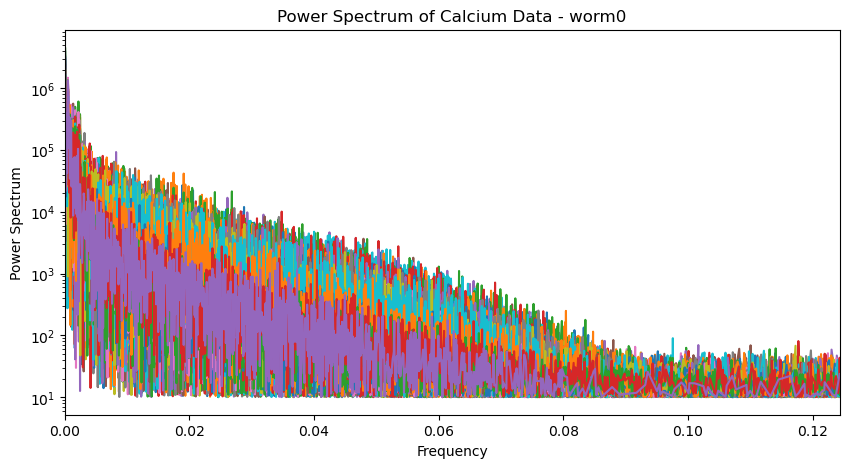

In [59]:
dataset = get_dataset(config=OmegaConf.load("/home/lrvnc/Projects/worm-graph/conf/dataset.yaml"))

for wormid in dataset.keys():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    oneWorm = dataset[wormid]
    for named_neuron in oneWorm['slot_to_named_neuron']:
        ts1D = oneWorm['calcium_data'][:, named_neuron].detach().numpy()
        ps = plot_power_spectrum(ts1D, sampling_rate=0.25, threshold=10.0, axis=ax)
    
    plt.title("Power Spectrum of Calcium Data - {}".format(oneWorm['worm']))
    plt.show()
    if wormid == 'worm0':
        break

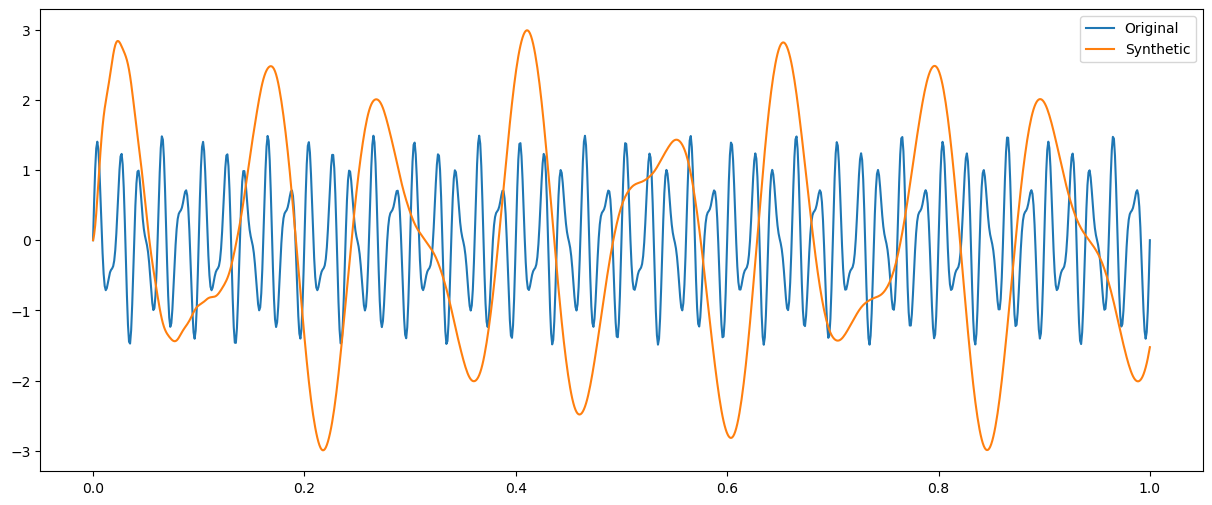

In [49]:
import numpy as np
import matplotlib.pyplot as plt

def synthesize_data(time_series):
    # Extract frequencies and amplitudes
    fft_vals = np.fft.fft(time_series)
    n = len(fft_vals)
    freqs = np.fft.fftfreq(n)

    # Extract the power (amplitude squared) and phase (angle)
    power = np.abs(fft_vals)**2
    power /= max(power)
    phases = np.angle(fft_vals)

    # Now, let's generate a synthetic time series
    synthetic_time_series = np.zeros_like(time_series)

    for i in range(n):
        synthetic_time_series += np.sqrt(power[i]) * np.cos(freqs[i] * np.arange(n) + phases[i])

    return synthetic_time_series

# Test the function
N = 1000
t = np.linspace(0.0, 1.0, N)
original_signal = np.sin(50.0 * 2.0*np.pi*t) + 0.5*np.sin(80.0 * 2.0*np.pi*t)

synthetic_signal = synthesize_data(original_signal)

plt.figure(figsize=(15, 6))
plt.plot(t, original_signal, label='Original')
plt.plot(t, synthetic_signal, label='Synthetic')
plt.legend()
plt.show()


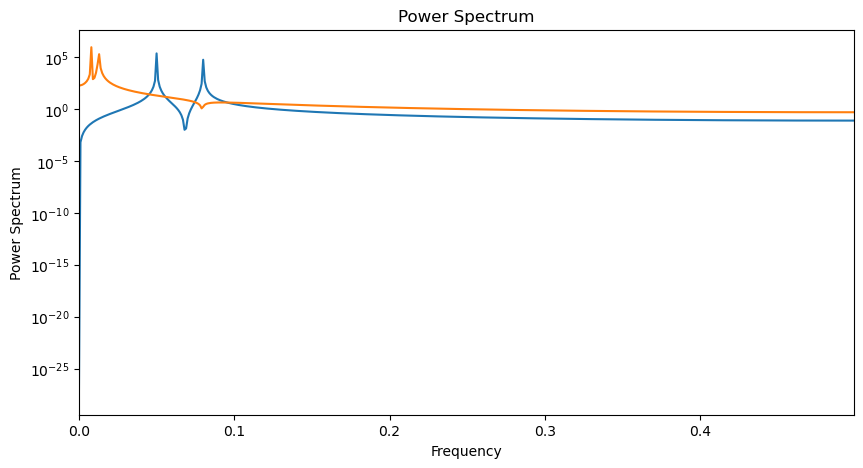

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ps = plot_power_spectrum(original_signal, sampling_rate=1.0, threshold=0.0, axis=ax)
ps = plot_power_spectrum(synthetic_signal, sampling_rate=1.0, threshold=0.0, axis=ax)
plt.show()

# Make synthetic worm datasets containing sinusoidal signals
---

In [77]:
import numpy as np
import pickle
import random
from sklearn.preprocessing import StandardScaler
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302


def create_synthetic_dataset(
    max_timesteps,
    num_worms=1,
    num_signal=302,
    num_named_neurons=302,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.10,
    noise_sd=0.01,
    transform=StandardScaler(),
    dataset_name="Synthetic0000",
):
    """
    Create synthetic worm datasets using a sum of sinusoidal functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_worms: The number of worms to create datasets for.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_named_neurons: The number of named neurons to create non-zero signals for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine functions to add together to create a signal.
    :param freq_gain: A multiplier for the frequencies of the calcium signal.
    :param delta_seconds: The constant time difference (in seconds) between each timepoint.
    :param transform: Standard deviation of the Gaussian noise.
    :param noise_sd: The sklearn transform to use for normalizing the data.
    :param dataset_name: The name to give the synthetic dataset.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = delta_seconds * np.arange(max_timesteps).reshape(
        -1, 1
    )  # Column vector

    # Create a memo of neurons to frequencies so that distinct neurons have distinct frequency signatures
    neuron_to_frequencies = dict()  # this will be consistent across worms

    # Create data for each worm
    for worm_idx in range(num_worms):
        # Create a memo of neurons to phases so that distinct neurons have distinct phase signatures
        neuron_to_phases = dict()  # this will vary across worms

        # Initialize worm data
        worm = f"worm{worm_idx}"
        worm_data = {}
        num_unknown_neurons = num_signal - num_named_neurons
        calcium_data = np.zeros((max_timesteps, num_signal))
        time_points = np.arange(max_timesteps)
        named_neuron_indices = random.sample(
            range(num_signal), num_named_neurons
        )  # random sampling without replacement
        named_neurons = set(NEURONS_302[i] for i in named_neuron_indices)

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {
            (neuron) if neuron in named_neurons else str(idx): idx
            for idx, neuron in enumerate(NEURONS_302)
        }
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        # Create calcium data
        for i in named_neuron_indices:
            # TODO: Give each particular neuron a characteristic frequency that is consistent across worms
            neuron_name = NEURONS_302[i]
            frequencies = neuron_to_frequencies.setdefault(
                neuron_name,
                [
                    # freq_gain
                    # * np.random.uniform(
                    #     1.0 / max_timesteps, 10.0 / max_timesteps
                    # )  # random frequency
                    freq_gain * 4.0 / max_timesteps  # deterministic frequency
                    for _ in range(sum_frequencies)
                ],
            )
            phases = neuron_to_phases.setdefault(
                neuron_name,
                [
                    np.random.random() * 2 * np.pi  # random phase
                    # 0.5 * 2 * np.pi  # deterministic phase
                    for _ in range(sum_frequencies)
                ],
            )

            # Add sine functions
            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            # Add noise
            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # Normalize data
        calcium_data = transform.fit_transform(calcium_data)

        # Smooth the data
        smooth_method = "FFT"
        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, smooth_method
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        original_dt = np.median(dt).item()
        resample_dt = delta_seconds
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, smooth_method
        )

        # Save the data
        worm_data["dataset"] = dataset_name
        worm_data["smooth_method"] = smooth_method
        worm_data["worm"] = worm
        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["original_median_dt"] = original_dt
        worm_data["resample_median_dt"] = resample_dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = num_signal
        worm_data["num_named_neurons"] = num_named_neurons
        worm_data["num_unknown_neurons"] = num_unknown_neurons

        worm_data = reshape_calcium_data(worm_data)

        dataset[worm] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3000
num_worms = 10
num_signal = 302
num_named_neurons = 302
file_name = "Synthetic0000"

# Creating and saving datasets
dataset = create_synthetic_dataset(
    max_timesteps,
    num_worms,
    num_signal,
    num_named_neurons,
    if_noise=False,
    sum_frequencies=1,
    freq_gain=1.0,
    delta_seconds=0.25,
    noise_sd=0.20,
    transform=StandardScaler(),
    dataset_name=file_name,
)
save_synthetic_dataset(f"../data/processed/neural/{file_name}.pickle", dataset)

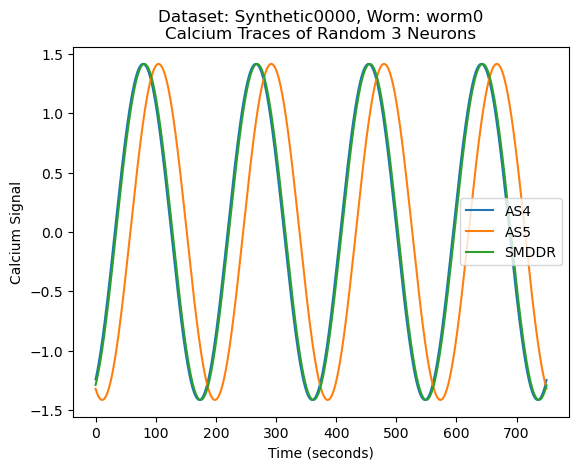

In [78]:
import pickle
from visualize._utils import plot_worm_data

# Load synthetic dataset
with open(f"../data/processed/neural/{file_name}.pickle", "rb") as f:
    dataset = pickle.load(f)

# Plot the first few calcium traces for the first worm
plot_worm_data(dataset["worm0"], num_neurons=3, smooth=False)